In [1]:
import numpy as np
import torch 
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torchvision.transforms as transforms
import os
import glob
from skimage import io
import random
from skimage.color import rgb2gray
!pip install timm
import timm
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 5.4 MB/s eta 0:00:00a 0:00:01


In [2]:
class EfficientNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.efficientnet = timm.create_model('tf_efficientnetv2_b0', pretrained=True, in_chans=1)
        self.fc = nn.Linear(1000, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.efficientnet(x)
        x = self.relu(x)
        x = self.fc(x)
        return x

In [3]:
class MyDataset(data.Dataset):
    def __init__(self, mode, transform, val_size):
        super().__init__()
        self.transform = transform
        self.mode = mode
        path1 = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/*/*.jpeg'
        path2 = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/*/*.jpeg'
        path3 = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/*/*.jpeg'
        all_paths = glob.glob(path1, recursive=True) + glob.glob(path2, recursive=True) + glob.glob(path3, recursive=True)
        random.Random(0).shuffle(all_paths)
        if mode == 'train':
            self.images_paths = all_paths[0: int(len(all_paths) * (1 - val_size))]
        elif mode == 'val':
            self.images_paths = all_paths[int(len(all_paths) * (1 - val_size)): ]
        self.labels_to_int = {'NORMAL': 0, 'PNEUMONIA': 1}

    def __getitem__(self, index):
        img = io.imread(self.images_paths[index])
        if len(img.shape) > 2: 
            img = rgb2gray(img)
        img = self.transform(img)
        label = self.images_paths[index].split(os.sep)[-2]
        label = self.labels_to_int[label]
        return img.float(), label

    def __len__(self):
        return len(self.images_paths)

In [4]:
loss_func = nn.CrossEntropyLoss()
batch_size = 64
learning_rate = 0.001
num_epochs = 7

In [5]:
val_size = 0.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = EfficientNet()
model = model.to(device)
train_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224))])
val_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224))])
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
train_dataset = MyDataset('train', train_transform, val_size)
val_dataset = MyDataset('val', val_transform, val_size)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-effv2-weights/tf_efficientnetv2_b0-c7cc451f.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnetv2_b0-c7cc451f.pth


In [6]:
for epoch in range(1, num_epochs + 1):
    print('epoch:', epoch)
    model.train()
    for samples, targets in train_loader:
        samples = samples.to(device)
        targets = targets.to(device)
        preds = model(samples)
        loss = loss_func(preds, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
    
    model.eval() 
    with torch.no_grad():
        for mode, loader in zip(['train', 'val'], [train_loader, val_loader]):
            epoch_loss, currect, num_samples = 0, 0, 0
            for samples, targets in loader:
                samples = samples.to(device)
                targets = targets.to(device)
                preds = model(samples)
                loss = loss_func(preds, targets)
                epoch_loss += loss.item() * targets.shape[0] 
                currect += (torch.argmax(preds, axis=1) == targets).sum()
                num_samples += targets.shape[0]

            epoch_loss = epoch_loss / num_samples
            accuracy = currect / num_samples
            print(mode, '- loss:', f'{epoch_loss:.2}', 'accuracy:', f'{accuracy:.2}')

epoch: 1
train - loss: 0.12 accuracy: 0.95
val - loss: 0.15 accuracy: 0.95
epoch: 2
train - loss: 0.035 accuracy: 0.99
val - loss: 0.1 accuracy: 0.98
epoch: 3
train - loss: 0.091 accuracy: 0.97
val - loss: 0.16 accuracy: 0.95
epoch: 4
train - loss: 0.018 accuracy: 0.99
val - loss: 0.077 accuracy: 0.98
epoch: 5
train - loss: 0.047 accuracy: 0.98
val - loss: 0.12 accuracy: 0.95
epoch: 6
train - loss: 0.012 accuracy: 1.0
val - loss: 0.11 accuracy: 0.97
epoch: 7
train - loss: 0.0034 accuracy: 1.0
val - loss: 0.094 accuracy: 0.98


In [7]:
torch.save(model.state_dict(), 'model.ckpt')

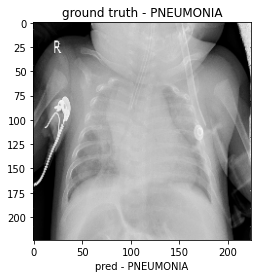

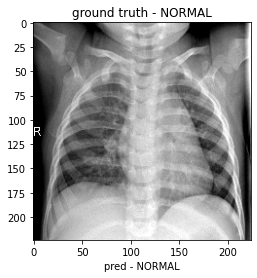

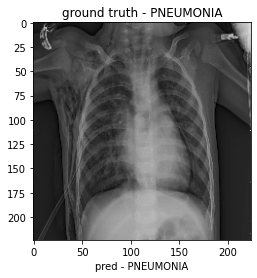

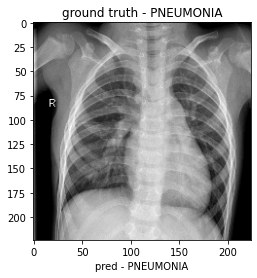

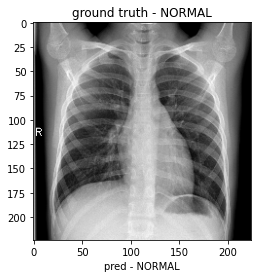

In [8]:
samples, targets = next(iter(val_loader))
samples = samples.to(device)
preds = model(samples)
preds = preds.detach().cpu().numpy()
targets = targets.detach().cpu().numpy()
samples = samples.permute(0, 2, 3, 1).detach().cpu().numpy()
preds = np.argmax(preds, axis=1)

int_to_labels = {0: 'NORMAL', 1: 'PNEUMONIA'}

for i in range(5):
    fig, ax = plt.subplots(1)
    ax.set_title('ground truth - ' + int_to_labels[targets[i]])
    ax.set_xlabel('pred - ' + int_to_labels[preds[i]])
    ax.imshow(samples[i], cmap='gray')
    
fig.show()    